# Programmatic access to Postgres

The SQL database, Postgres here, is used "programmatically": this means the code is in Python to interact with the database, similarly to how developers build a web application. This script makes also use of transactions to guarantee that updates to the database in response to the user's request are atomic and consistent.

- Load the SQL extension to access the databases

In [1]:
%load_ext sql

- Connect to the database. This should work for the docker-based setup.

In [2]:
%sql postgresql://postgres:example@db:5432

In [3]:
# install packages if not yet available:
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install -U pandasql

- Set up the schema for a bank and a table that will contain the loan data

In [4]:
%%sql
drop schema if exists bank cascade;

create schema bank;

create table bank.loan_data(    
    age INTEGER,
    income NUMERIC,
    loan_amount NUMERIC,
    credit_score INTEGER,
    months_employed INTEGER,
    num_credit_lines INTEGER,
    interest_rate NUMERIC,
    loan_term INTEGER,
    dti_ratio NUMERIC,
    education VARCHAR,
    employment_type VARCHAR,
    marital_status VARCHAR,
    has_mortgage BOOLEAN,
    has_dependents BOOLEAN,
    loan_purpose VARCHAR,
    has_cosigner BOOLEAN,
    loan_default BOOLEAN
)

 * postgresql://postgres:***@db:5432
Done.
Done.
Done.


[]

- Load the data from the csv-file into the newly created database

In [5]:
%%sql
COPY bank.loan_data 
FROM '/tmp/df_small_sampled.csv' CSV HEADER;

 * postgresql://postgres:***@db:5432
10000 rows affected.


[]

In [6]:
# If there is any error due to the csv-file being not yet available in the Postgres Container, run this in the terminal:
# docker cp "/path_to/Masters Thesis/Python/Appendices/ETL Process/notebooks/df_small_sampled.csv" etlprocess-db-1:/tmp/df_small_sampled.csv

- Since the SQL extension is enabled, the user can either directly write SQL code or switch to Python

In [7]:
%%sql
SELECT * FROM bank.loan_data LIMIT 10;

 * postgresql://postgres:***@db:5432
10 rows affected.


age,income,loan_amount,credit_score,months_employed,num_credit_lines,interest_rate,loan_term,dti_ratio,education,employment_type,marital_status,has_mortgage,has_dependents,loan_purpose,has_cosigner,loan_default
28,68559,197371,366,52,4,9.14,24,0.3,High School,Part-time,Married,True,True,Other,False,False
43,39215,124625,542,78,1,24.71,12,0.69,Bachelor's,Self-employed,Divorced,True,True,Education,False,False
64,128993,223067,744,55,3,17.39,12,0.75,High School,Self-employed,Divorced,False,True,Business,False,False
18,33343,74830,606,88,4,5.36,48,0.21,PhD,Part-time,Divorced,False,False,Other,True,False
33,45746,172492,731,23,3,24.81,36,0.1,PhD,Unemployed,Married,True,True,Home,True,False
69,87356,102551,459,63,2,17.73,48,0.88,High School,Full-time,Married,True,True,Auto,True,False
62,117064,13349,444,38,1,24.07,60,0.48,Master's,Part-time,Divorced,False,True,Education,True,False
42,101125,147737,526,59,2,16.72,48,0.16,PhD,Full-time,Single,False,False,Education,False,False
22,134932,187314,629,61,1,15.9,48,0.76,PhD,Full-time,Single,False,True,Auto,False,False
38,148692,12215,667,66,4,7.56,36,0.53,PhD,Self-employed,Single,False,True,Home,True,False


## Psycopg2
- Psycopg2 is (one of) the python libraries to interact with a Postgres instance. Furthermore `datetime` is needed, which will later be needed to construct a `datetime`.
- Documentation for psycopg2 is avaialable here: [https://www.psycopg.org/docs/](https://www.psycopg.org/docs/)

In [8]:
import psycopg2
import datetime

- `psycopg2` is used to connect directly to the database and gives back a handle to the connection as follows. This should work for the docker-based setup.

In [9]:
conn = psycopg2.connect('postgresql://postgres:example@db:5432')
conn

<connection object at 0x7f8e74171a40; dsn: 'user=postgres password=xxx host=db port=5432', closed: 0>

*Note*: if there is any unexpected errors when running queries, it may be that the `cursor` or connection are in an invalid state, then a rollback may help. This usually resolves the problem. Else a full restart of the python kernel is needed.

In [10]:
conn.rollback()

## Executing queries

> The class `cursor` allows interaction with the database:
> * send commands to the database using methods such as `execute()` and `executemany()`,
> * retrieve data from the database by iteration or using methods such as `fetchone()`, `fetchmany()`, `fetchall()`.

In [11]:
cur = conn.cursor()

In [12]:
cur.execute('select * from bank.loan_data LIMIT 3')

This only sends the query to the database, but doesn't start obtaining the results yet. Therefore, one needs to iterate over the cursor:

In [13]:
for record in cur:
    print(record)

(28, Decimal('68559'), Decimal('197371'), 366, 52, 4, Decimal('9.14'), 24, Decimal('0.3'), 'High School', 'Part-time', 'Married', True, True, 'Other', False, False)
(43, Decimal('39215'), Decimal('124625'), 542, 78, 1, Decimal('24.71'), 12, Decimal('0.69'), "Bachelor's", 'Self-employed', 'Divorced', True, True, 'Education', False, False)
(64, Decimal('128993'), Decimal('223067'), 744, 55, 3, Decimal('17.39'), 12, Decimal('0.75'), 'High School', 'Self-employed', 'Divorced', False, True, 'Business', False, False)


- Another possibility is called `fetchall` to automatically obtain all results in a single list. To avoid an empty resultset, need to re-run the query first.

In [14]:
cur = conn.cursor()
cur.execute('select * from bank.loan_data LIMIT 3')
cur.fetchall()

[(28,
  Decimal('68559'),
  Decimal('197371'),
  366,
  52,
  4,
  Decimal('9.14'),
  24,
  Decimal('0.3'),
  'High School',
  'Part-time',
  'Married',
  True,
  True,
  'Other',
  False,
  False),
 (43,
  Decimal('39215'),
  Decimal('124625'),
  542,
  78,
  1,
  Decimal('24.71'),
  12,
  Decimal('0.69'),
  "Bachelor's",
  'Self-employed',
  'Divorced',
  True,
  True,
  'Education',
  False,
  False),
 (64,
  Decimal('128993'),
  Decimal('223067'),
  744,
  55,
  3,
  Decimal('17.39'),
  12,
  Decimal('0.75'),
  'High School',
  'Self-employed',
  'Divorced',
  False,
  True,
  'Business',
  False,
  False)]

## Formatting

- To get a human-readable output for the front office, one can handle the output in Python:

In [15]:
def show_loans():
    with conn.cursor() as cur:
        cur.execute('SELECT * FROM bank.loan_data LIMIT 3')
        print("Loan Overview:")
        print("-" * 40)
        for loan in cur:
            age, balance, available_credit = loan[0], loan[1], loan[2]
            print(f"Age: {age} | Balance: {balance} CHF | Available Credit: {available_credit} CHF")
        
        # To release resources, the cursor may be manually closed:
        cur.close()

In [16]:
show_loans()

Loan Overview:
----------------------------------------
Age: 28 | Balance: 68559 CHF | Available Credit: 197371 CHF
Age: 43 | Balance: 39215 CHF | Available Credit: 124625 CHF
Age: 64 | Balance: 128993 CHF | Available Credit: 223067 CHF


- In a real banking application, this information might be displayed on a web page for the user.

## Prepared statements

- The next section is on how parameters can be passed to the query that the user has provided.
- Given a simple query: displaying the loan description for a certain age groups. Python allows to use `%s` as a placeholder in the sql for the query parameters. 

In [17]:
def get_loans_from_age_group(age_lower_bound, age_upper_bound):
    cur = conn.cursor()
    cur.execute(
        'SELECT age, income, loan_amount, education FROM bank.loan_data WHERE age >= %s AND age <= %s LIMIT 10',
        (age_lower_bound, age_upper_bound)
    )
    
    for age, income, loan_amount, education in cur:
        print(f'Age: {age} | Income: {income} CHF | Loan Amount: {loan_amount} CHF | Education: {education}')
    
    cur.close()

In [18]:
get_loans_from_age_group(20, 30)

Age: 28 | Income: 68559 CHF | Loan Amount: 197371 CHF | Education: High School
Age: 22 | Income: 134932 CHF | Loan Amount: 187314 CHF | Education: PhD
Age: 21 | Income: 136627 CHF | Loan Amount: 96864 CHF | Education: PhD
Age: 28 | Income: 92615 CHF | Loan Amount: 91548 CHF | Education: PhD
Age: 30 | Income: 19600 CHF | Loan Amount: 105318 CHF | Education: Master's
Age: 26 | Income: 120624 CHF | Loan Amount: 208500 CHF | Education: Master's
Age: 27 | Income: 84818 CHF | Loan Amount: 118939 CHF | Education: Master's
Age: 21 | Income: 55550 CHF | Loan Amount: 207213 CHF | Education: High School
Age: 25 | Income: 111542 CHF | Loan Amount: 84382 CHF | Education: High School
Age: 27 | Income: 23440 CHF | Loan Amount: 163564 CHF | Education: High School


## Updates from `python` − Changing fact tables and inserting new loans
- The cursors and prepared statements via `psycopg2` allows to update the database, given new input from the credit officers.
- If the Credit Risk Department grants a new loan this will be necessary to keep track of the risk.

In [19]:
cur = conn.cursor()
cur.execute(
    'UPDATE bank.loan_data SET Income = 0 WHERE Age >= %s',
    (65,)  # Note the comma — this makes it a tuple
)
conn.commit()

- For a loan amount to change a `commit` call is needed because running a query automatically starts a transaction for a `connection` in `psycopg2`, and requires commitment of transaction so that the changes become visible globally.

In [20]:
get_loans_from_age_group(65, 100)

Age: 69 | Income: 0 CHF | Loan Amount: 110267 CHF | Education: PhD
Age: 69 | Income: 0 CHF | Loan Amount: 172254 CHF | Education: Bachelor's
Age: 65 | Income: 0 CHF | Loan Amount: 171956 CHF | Education: Master's
Age: 67 | Income: 0 CHF | Loan Amount: 98479 CHF | Education: High School
Age: 68 | Income: 0 CHF | Loan Amount: 96851 CHF | Education: High School
Age: 68 | Income: 0 CHF | Loan Amount: 109379 CHF | Education: Master's
Age: 68 | Income: 0 CHF | Loan Amount: 14758 CHF | Education: High School
Age: 68 | Income: 0 CHF | Loan Amount: 186382 CHF | Education: Master's
Age: 66 | Income: 0 CHF | Loan Amount: 161320 CHF | Education: Master's
Age: 69 | Income: 0 CHF | Loan Amount: 102551 CHF | Education: High School


In [21]:
%%sql
-- Create materialized view with 300 random rows including new columns with defaults for computational reasons
CREATE MATERIALIZED VIEW bank.loan_data_sample AS
SELECT 
    l.*,
    'system' AS entered_by,  -- Default value for entered_by
    CURRENT_TIMESTAMP AS entry_datetime  -- Default value for timestamp
FROM bank.loan_data l
ORDER BY RANDOM()
LIMIT 300;



 * postgresql://postgres:***@db:5432
300 rows affected.


[]

In [22]:
%%sql
-- Create a regular table with the same structure
CREATE TABLE bank.loan_data_editable AS
SELECT * FROM bank.loan_data_sample;

 * postgresql://postgres:***@db:5432
300 rows affected.


[]

In [23]:
def insert_new_loan(loan, entered_by):
    cur = conn.cursor()
    try:
        # First insert into the base table
        cur.execute('''
            INSERT INTO bank.loan_data_editable (
                age, income, loan_amount, credit_score, months_employed, 
                num_credit_lines, interest_rate, loan_term, dti_ratio, 
                education, employment_type, marital_status, has_mortgage, 
                has_dependents, loan_purpose, has_cosigner, loan_default,
                entered_by, entry_datetime
            ) VALUES (
                %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, 
                %s, %s, %s, %s, %s, %s, %s, %s, NOW()
            )
        ''', loan + (entered_by,))
        
        # Then refresh the materialized view
        cur.execute('REFRESH MATERIALIZED VIEW bank.loan_data_sample')
        conn.commit()
    except Exception as e:
        conn.rollback()
        raise e
    finally:
        cur.close()

In [24]:
# New loan granted
new_loan = (
    28, 68559, 197371, 366, 52, 4, 9.14, 24, 0.3,
    'High School', 'Part-time', 'Married', True, True, 'Other', False, False
)

# Execute the insertion
insert_new_loan(new_loan, entered_by='credit_officer_1')

# Verify the insertion
cur = conn.cursor()
cur.execute("""
    SELECT loan_amount, entered_by, entry_datetime 
    FROM bank.loan_data_editable
    WHERE entered_by = 'credit_officer_1'
    ORDER BY entry_datetime DESC
    LIMIT 1
""")
latest_loan = cur.fetchone()
print(f"Latest inserted loan: {latest_loan}")
cur.close()

# Close connection
conn.close()

Latest inserted loan: (Decimal('197371'), 'credit_officer_1', datetime.datetime(2025, 6, 13, 9, 31, 4, 994083, tzinfo=datetime.timezone.utc))


---

# OLAP Analysis of Bank Loan Portfolio

Next a multidimensional analysis of the bank's loan data using OLAP (Online Analytical Processing) techniques to uncover hidden patterns and business insights will be carried out. The 3 data cubes created enable slicing-and-dicing of loan performance across multiple dimensions simultaneously.

## CUBE Operations:

1) Creating multi-dimensional aggregations with GROUP BY CUBE()

- Generating all possible grouping combinations automatically

2) Drill-Down Analysis:

- From high-level categories (like credit tiers) to detailed segments. Examining how default rates vary across 5+ dimensions

3) Slice-and-Dice:

- Isolating specific risk factors (credit score × loan purpose × demographics). Comparing profitability across different product configurations

4) Calculated Metrics:

- Derived measures like default rates and profitability metrics.

## 1. Loan Performance Cube

In [25]:
%%sql
-- Loan performance by credit score bracket and loan purpose
SELECT 
    CASE 
        WHEN credit_score < 580 THEN 'Poor (<580)'
        WHEN credit_score BETWEEN 580 AND 669 THEN 'Fair (580-669)'
        WHEN credit_score BETWEEN 670 AND 739 THEN 'Good (670-739)'
        WHEN credit_score BETWEEN 740 AND 799 THEN 'Very Good (740-799)'
        ELSE 'Excellent (800+)' 
    END AS credit_tier,
    loan_purpose,
    COUNT(*) AS total_loans,
    ROUND(AVG(loan_amount),0) AS avg_loan_size,
    ROUND(100.0 * SUM(CASE WHEN loan_default THEN 1 ELSE 0 END) / COUNT(*), 2) AS default_rate,
    ROUND(AVG(interest_rate),1) AS avg_interest_rate
FROM bank.loan_data_editable
GROUP BY CUBE(credit_tier, loan_purpose)
ORDER BY credit_tier, loan_purpose;

 * postgresql://postgres:***@db:5432
36 rows affected.


credit_tier,loan_purpose,total_loans,avg_loan_size,default_rate,avg_interest_rate
Excellent (800+),Auto,5,166580,40.00,16.1
Excellent (800+),Business,8,179876,25.00,16.4
Excellent (800+),Education,4,86797,75.00,19.2
Excellent (800+),Home,10,140617,30.00,15.5
Excellent (800+),Other,6,167103,50.00,12.9
Excellent (800+),None,33,152360,39.39,15.8
Fair (580-669),Auto,5,114778,40.00,13.9
Fair (580-669),Business,6,176120,33.33,16.0
Fair (580-669),Education,9,144281,22.22,12.8
Fair (580-669),Home,15,106259,20.00,13.0


## 2. Demographic Risk Analysis Cube

In [26]:
%%sql
-- Demographic risk analysis by age group, education, and employment
SELECT 
    CASE 
        WHEN age < 25 THEN '18-24'
        WHEN age BETWEEN 25 AND 34 THEN '25-34'
        WHEN age BETWEEN 35 AND 44 THEN '35-44'
        WHEN age BETWEEN 45 AND 54 THEN '45-54'
        WHEN age BETWEEN 55 AND 64 THEN '55-64'
        ELSE '65+' 
    END AS age_group,
    education,
    employment_type,
    COUNT(*) AS loan_count,
    ROUND(AVG(dti_ratio),2) AS avg_dti,
    ROUND(100.0 * SUM(CASE WHEN loan_default THEN 1 ELSE 0 END) / COUNT(*), 2) AS default_rate
FROM bank.loan_data_editable
GROUP BY CUBE(age_group, education, employment_type)
ORDER BY age_group, education, employment_type;

 * postgresql://postgres:***@db:5432
170 rows affected.


age_group,education,employment_type,loan_count,avg_dti,default_rate
18-24,Bachelor's,Full-time,5,0.60,80.00
18-24,Bachelor's,Part-time,3,0.72,66.67
18-24,Bachelor's,Self-employed,2,0.71,50.00
18-24,Bachelor's,Unemployed,1,0.34,0.00
18-24,Bachelor's,None,11,0.63,63.64
18-24,High School,Full-time,1,0.64,0.00
18-24,High School,Part-time,3,0.57,66.67
18-24,High School,Self-employed,1,0.20,100.00
18-24,High School,Unemployed,4,0.44,100.00
18-24,High School,None,9,0.48,77.78


## 3. Profitability Cube

In [27]:
%%sql
-- Loan profitability by term and interest rate tier
SELECT 
    loan_term,
    CASE 
        WHEN interest_rate < 5 THEN 'Low (<5%)'
        WHEN interest_rate BETWEEN 5 AND 7.99 THEN 'Medium (5-8%)'
        WHEN interest_rate BETWEEN 8 AND 10.99 THEN 'High (8-11%)'
        ELSE 'Very High (12%+)' 
    END AS rate_tier,
    COUNT(*) AS loan_count,
    ROUND(SUM(loan_amount * interest_rate/100 * loan_term/12),2) AS estimated_revenue,
    SUM(CASE WHEN loan_default THEN loan_amount ELSE 0 END) AS defaulted_amount,
    ROUND(SUM(loan_amount * interest_rate/100 * loan_term/12) - 
    SUM(CASE WHEN loan_default THEN loan_amount ELSE 0 END),2) AS estimated_profit
FROM bank.loan_data_editable
GROUP BY CUBE(loan_term, rate_tier)
ORDER BY loan_term, rate_tier;

 * postgresql://postgres:***@db:5432
30 rows affected.


loan_term,rate_tier,loan_count,estimated_revenue,defaulted_amount,estimated_profit
12,High (8-11%),6,32829.09,0,32829.09
12,Low (<5%),9,40994.25,383133,-342138.75
12,Medium (5-8%),10,63076.59,234708,-171631.41
12,Very High (12%+),41,1015136.08,2694644,-1679507.92
12,None,66,1152036.01,3312485,-2160448.99
24,High (8-11%),9,219046.20,0,219046.20
24,Low (<5%),5,27868.73,0,27868.73
24,Medium (5-8%),6,133190.80,439991,-306800.20
24,Very High (12%+),50,2367900.05,2952316,-584415.95
24,None,70,2748005.78,3392307,-644301.22


 * postgresql://postgres:***@db:5432
301 rows affected.


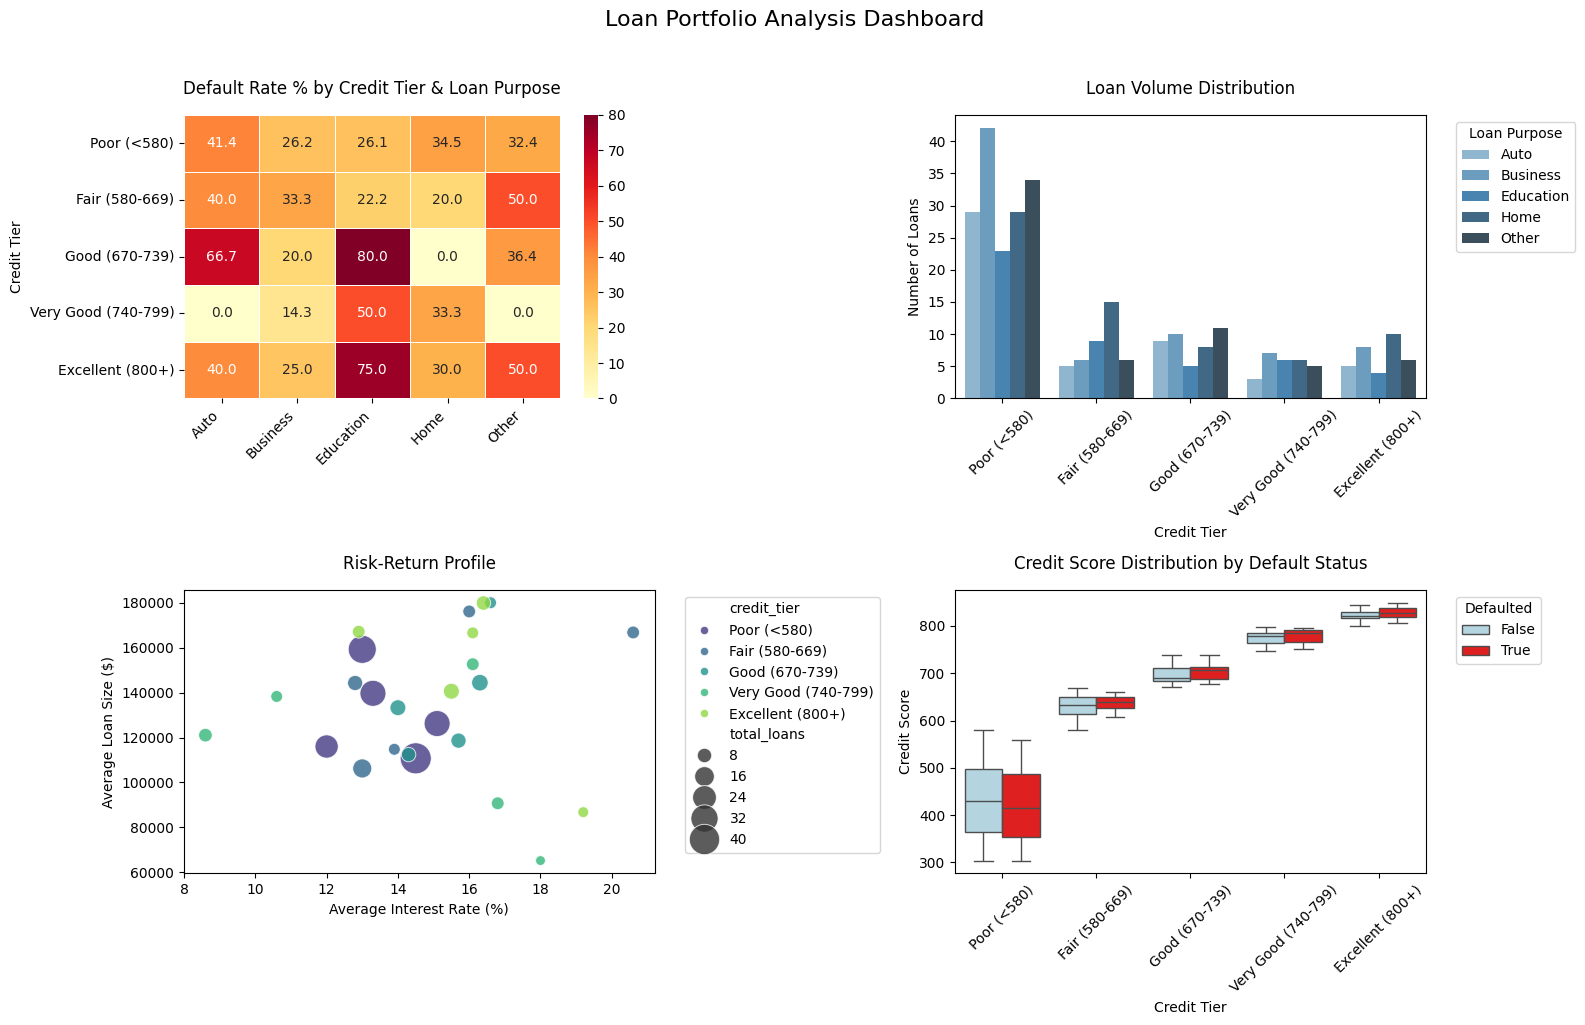

,credit_tier,loan_purpose,total_loans,avg_loan_size,default_rate,avg_interest_rate
0,Poor (<580),Auto,29,"$126,239",41.4%,15.1%
1,Poor (<580),Business,42,"$110,759",26.2%,14.5%
2,Poor (<580),Education,23,"$116,018",26.1%,12.0%
3,Poor (<580),Home,29,"$139,693",34.5%,13.3%
4,Poor (<580),Other,34,"$159,267",32.4%,13.0%
5,Fair (580-669),Auto,5,"$114,778",40.0%,13.9%
6,Fair (580-669),Business,6,"$176,120",33.3%,16.0%
7,Fair (580-669),Education,9,"$144,281",22.2%,12.8%
8,Fair (580-669),Home,15,"$106,259",20.0%,13.0%
9,Fair (580-669),Other,6,"$166,775",50.0%,20.6%


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Run the SQL query and load results into a DataFrame
loan_cube = %sql SELECT * FROM bank.loan_data_editable
df = loan_cube.DataFrame()

# Data Preparation
# Convert credit_score to numeric and create credit tiers
df['credit_score'] = pd.to_numeric(df['credit_score'], errors='coerce')
bins = [0, 580, 670, 740, 800, float('inf')]
labels = ['Poor (<580)', 'Fair (580-669)', 'Good (670-739)', 'Very Good (740-799)', 'Excellent (800+)']
df['credit_tier'] = pd.cut(df['credit_score'], bins=bins, labels=labels, right=False)

# Aggregate data with explicit observed=True
cube_data = df.groupby(['credit_tier', 'loan_purpose'], observed=True).agg(
    total_loans=('loan_amount', 'count'),
    avg_loan_size=('loan_amount', lambda x: round(x.mean(), 0)),
    default_rate=('loan_default', lambda x: round(100*x.mean(), 2)),
    avg_interest_rate=('interest_rate', lambda x: round(x.mean(), 1))
).reset_index()

# Visualization Setup
plt.figure(figsize=(16, 10))
plt.suptitle('Loan Portfolio Analysis Dashboard', y=1.02, fontsize=16)

# 1. Default Rate Heatmap (with observed=True)
plt.subplot(2, 2, 1)
heatmap_data = cube_data.pivot_table(
    index="credit_tier", 
    columns="loan_purpose", 
    values="default_rate", 
    fill_value=0,
    observed=True  # Added to suppress warning
)
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=.5)
plt.title("Default Rate % by Credit Tier & Loan Purpose", pad=15)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Credit Tier')

# 2. Loan Volume Bar Plot
plt.subplot(2, 2, 2)
sns.barplot(
    data=cube_data, 
    x="credit_tier", 
    y="total_loans", 
    hue="loan_purpose",
    order=labels, 
    palette="Blues_d"
)
plt.title("Loan Volume Distribution", pad=15)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Loan Purpose')
plt.xlabel('Credit Tier')
plt.ylabel('Number of Loans')

# 3. Interest Rate vs Loan Size Bubble Plot
plt.subplot(2, 2, 3)
scatter = sns.scatterplot(
    data=cube_data, 
    x="avg_interest_rate", 
    y="avg_loan_size",
    hue="credit_tier", 
    size="total_loans",
    sizes=(50, 500), 
    palette="viridis",
    alpha=0.8
)
plt.title("Risk-Return Profile", pad=15)
plt.xlabel("Average Interest Rate (%)")
plt.ylabel("Average Loan Size ($)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Credit Score Distribution
plt.subplot(2, 2, 4)
sns.boxplot(
    data=df.dropna(subset=['credit_score']), 
    x="credit_tier", 
    y="credit_score", 
    hue="loan_default",
    order=labels,
    palette={False: "lightblue", True: "red"},
    showfliers=False
)
plt.title("Credit Score Distribution by Default Status", pad=15)
plt.xlabel("Credit Tier")
plt.ylabel("Credit Score")
plt.legend(title="Defaulted", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

# Display formatted table
styled_table = cube_data.style \
    .background_gradient(cmap="YlOrRd", subset=['default_rate']) \
    .format({
        'avg_loan_size': '${:,.0f}', 
        'avg_interest_rate': '{:.1f}%',
        'default_rate': '{:.1f}%'
    }) \
    .set_caption("Loan Performance Metrics by Credit Tier and Loan Purpose") \
    .set_properties(**{'text-align': 'center'})

display(styled_table)

---